In [2]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LayerNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard

In [93]:
import tensorflow as tf

In [4]:
df1 = pd.read_csv ("/content/train.csv")
df = np.array(df1)[:,1:]
df.shape

(745, 4)

In [5]:
df

array([[1.14388639e-02, 2.69056891e-03, 1.20643741e-03, 6.94671963e-03],
       [6.31663784e-04, 7.27739554e-03, 4.04865224e-03, 7.44992466e-05],
       [1.78279555e-02, 2.82101461e-02, 7.75795818e-03, 7.38221318e-03],
       ...,
       [7.68299427e-03, 1.95758627e-03, 7.00224191e-03, 6.46675926e-03],
       [3.39558900e-03, 1.27959071e-03, 7.62073818e-03, 1.68006760e-03],
       [4.59119924e-03, 6.67492170e-03, 7.59995590e-03, 9.55986473e-03]])

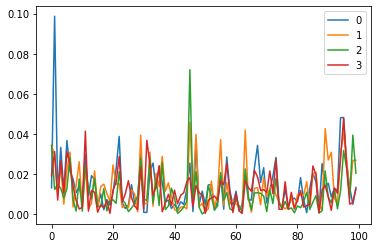

In [207]:
def sample_data(n_samples):
    index = np.random.randint(len(df), size=(1, n_samples))
    vectors = df[index,:]
    return vectors

ax = pd.DataFrame(sample_data(100)[0]).plot()

In [208]:
def get_generative(G_in, dense_dim=50, out_dim=2, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Dense(128, activation='sigmoid')(x)
    x = Dense(50, activation='sigmoid')(x)
    x = Dense(256, activation='sigmoid')(x)
    x = Dense(128, activation='sigmoid')(x)
    G_out = Dense(out_dim, activation='softmax')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[2])
G, G_out = get_generative(G_in)
G.summary()


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_109 (Dense)            (None, 50)                150       
_________________________________________________________________
dense_110 (Dense)            (None, 128)               6528      
_________________________________________________________________
dense_111 (Dense)            (None, 50)                6450      
_________________________________________________________________
dense_112 (Dense)            (None, 256)               13056     
_________________________________________________________________
dense_113 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_114 (Dense)            (None, 2)                 258

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [213]:
# Code sticks here yet is a good start


def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=128, conv_sz=4, leak=.2):
    #x = Reshape((-1, 1))(D_in)
    #x = Conv1D(n_channels, conv_sz, activation='sigmoid')(x)
    #x = Dropout(drate)(x)
    #x = Flatten()(x)
    x = Dense(n_channels, activation='sigmoid')(D_in)
    x = Dense(n_channels+150, activation='sigmoid')(x)
    x = Dense(n_channels+500, activation='tanh')(x)
    D_out = Dense(1, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[2])
D, D_out = get_discriminative(D_in)
D.summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_133 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_134 (Dense)            (None, 278)               35862     
_________________________________________________________________
dense_135 (Dense)            (None, 628)               175212    
_________________________________________________________________
dense_136 (Dense)            (None, 1)                 629       
Total params: 212,087
Trainable params: 212,087
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [215]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([2])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
model_33 (Functional)        (None, 2)                 59338     
_________________________________________________________________
model_38 (Functional)        (None, 1)                 212087    
Total params: 271,425
Trainable params: 59,338
Non-trainable params: 212,087
_________________________________________________________________


In [228]:
def sample_data_and_gen(G, noise_dim=2, n_samples=1):
    XT = sample_data(n_samples=n_samples)[0][:,:2]
    XN_noise = np.random.normal(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    #print(XT,XN)
    X = np.concatenate((XT, XN))

    y = np.zeros((n_samples+len(XN),1))

    y[ :n_samples, :] = 0
    y[n_samples: , :]  = 1
    return X, y

def pretrain(G, D, noise_dim=2, n_samples=1, batch_size=62):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

1/1 [==============================] - 0s 469ms/step - loss: 0.7362


In [227]:
sample_data(n_samples=1)[0][:,:2]

array([[0.0125547 , 0.00384505]])

In [229]:
def sample_noise(G, noise_dim=2, n_samples=1):
    X = np.random.normal(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 1))
    y[:, 0] = 1

    return X, y

def train(GAN, G, D, epochs=1000, n_samples=1, noise_dim=2, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #50: Generative Loss: 0.7566568851470947, Discriminative Loss: 0.6798907518386841
Epoch #100: Generative Loss: 0.5736957788467407, Discriminative Loss: 0.5724962949752808
Epoch #150: Generative Loss: 0.018256140872836113, Discriminative Loss: 0.024104464799165726
Epoch #200: Generative Loss: 0.0030417735688388348, Discriminative Loss: 0.003346532816067338
Epoch #250: Generative Loss: 0.0017516374355182052, Discriminative Loss: 0.0017552278004586697
Epoch #300: Generative Loss: 0.0011115849483758211, Discriminative Loss: 0.0010353501420468092
Epoch #350: Generative Loss: 0.0007464497466571629, Discriminative Loss: 0.0007296117837540805
Epoch #400: Generative Loss: 0.0005976198008283973, Discriminative Loss: 0.00067357491934672
Epoch #450: Generative Loss: 0.00047719807480461895, Discriminative Loss: 0.0005187720526009798
Epoch #500: Generative Loss: 0.0003784455475397408, Discriminative Loss: 0.0003837673575617373
Epoch #550: Generative Loss: 0.00030576970311813056, Discriminative

Text(0, 0.5, 'Loss')

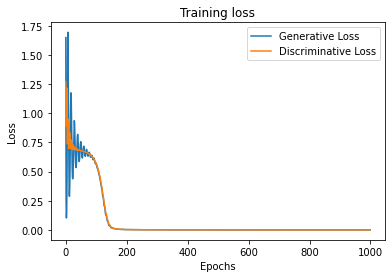

In [230]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=False)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")


In [ ]:
test = np.random.normal(0, 1, size=[410, 2])
print(test)
x =pd.DataFrame(G(test).numpy())

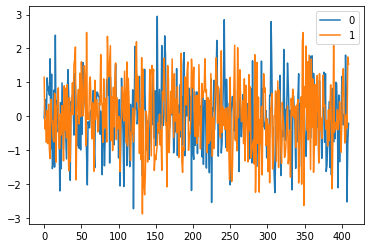

In [234]:
y =pd.DataFrame(test)
y.plot()

In [ ]:
G(test)